In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**PRODUCT RECOMMENTATION BASED ON VISIUAL SIMILARITY**

The goal of this experiment is to make a very basic recommender system: for a 
given fashion product, we want to recommend products that look similar.

This kind of recommender system is often used when browsing shopping websites. They usually appear on product pages as a "you may also like" section.

The idea behind this recommender system is simple: if a customer is showing interest towards a product by browsing its page, he may also be interested by products that are similar.

**IMPORT AND PARAMETERS SETUP**

In [ ]:
import numpy as np 
import pandas as pd 
import os 

In [ ]:
# imports
from keras.applications import vgg16
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input

from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

In [ ]:
import imageio
from keras.models import Model
from keras.applications import vgg16
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageOps, ImageFilter
import scipy.ndimage as ndi
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing import image
from keras.utils import plot_model

In [ ]:
# parameters setup

imgs_path = "/content/drive/MyDrive/products/pro/style/"
imgs_model_width, imgs_model_height = 224,224

nb_closest_images = 5 # number of most similar images to retrieve

 **LOAD THE VGG PRE-TRAINED MODEL FROM KERAS.**

Keras module contains several pre-trained models that can be  loaded very easily.

For our recommender system based on visual similarity, we need to load a Convolutional Neural Network (CNN) that will be able to interpret the image contents.

In this example we will load the VGG16 model trained on imagenet, a big labeled images database.

If we take the whole model, we will get an output containing probabilities to belong to certain classes, but that is not what we want.

We want to retrieve all the information that the model was able to get in the images.

In order to do so, we have to remove the last layers of the CNN which are only used for classes predictions.

In [ ]:
# load the model
vgg_model = vgg16.VGG16(weights='imagenet')

# remove the last layers in order to get features instead of predictions
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# print the layers of the CNN
feat_extractor.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

**GET THE IMAGE PATH**

In [ ]:
files = [imgs_path + x for x in os.listdir(imgs_path) if "png" in x]

print("number of images:",len(files))

number of images: 2194


**FEED AN ONE IMAGE IN TO THE CNN**

First we observe what output we get when putting one image into the CNN.

The following steps are:

1. loading the image
2. preparing the image to feed it into the CNN
3. get the CNN output which will correspond to the image features

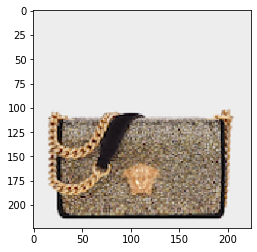

image loaded successfully!


In [ ]:
# load an image in PIL format
original = load_img(files[0], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("image loaded successfully!")


In [ ]:
# convert the PIL image to a numpy array
# in PIL - image is in (width, height, channel)
# in Numpy - image is in (height, width, channel)

numpy_image = img_to_array(original)

# convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# we want the input matrix to the network to be of the form (batchsize, height, width, channels)
# thus we add the extra dimension to the axis 0.

image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)

# prepare the image for the VGG model

processed_image = preprocess_input(image_batch.copy())

image batch size (1, 224, 224, 3)


In [ ]:
# get the extracted features
img_features = feat_extractor.predict(processed_image)

print("features successfully extracted!")
print("number of image features:",img_features.size)
img_features

1/1 [==============================] - 1s 1s/step
features successfully extracted!
number of image features: 4096


array([[0.       , 0.3754241, 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

**FEED ALL IMAGE IN TO THE CNN**

We were able to do the feature extraction process for one image. Now let's do it for all our images!

In [ ]:
# load all the images and prepare them for feeding into the CNN

importedImages = []

for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    
    importedImages.append(image_batch)
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [ ]:
# extract the images features

imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

69/69 [==============================] - 1280s 18s/step
features successfully extracted!


(2194, 4096)

**COMPUTE COSINE SIMILARITIES**

Now that we have features for every image, we can compute similarity metrics between every image couple.

We will use here the cosine similarity metric.

In [ ]:
# compute cosine similarities between images

cosSimilarities = cosine_similarity(imgs_features)

# store the results into a pandas dataframe

cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df.head()

,/content/drive/MyDrive/products/pro/style/5_2_060.png,/content/drive/MyDrive/products/pro/style/3_9_005.png,/content/drive/MyDrive/products/pro/style/3_8_003.png,/content/drive/MyDrive/products/pro/style/4_2_025.png,/content/drive/MyDrive/products/pro/style/4_6_027.png,/content/drive/MyDrive/products/pro/style/4_1_020.png,/content/drive/MyDrive/products/pro/style/4_2_035.png,/content/drive/MyDrive/products/pro/style/3_6_033.png,/content/drive/MyDrive/products/pro/style/3_9_014.png,/content/drive/MyDrive/products/pro/style/4_1_036.png,...,/content/drive/MyDrive/products/pro/style/2_0_060.png,/content/drive/MyDrive/products/pro/style/3_5_003.png,/content/drive/MyDrive/products/pro/style/2_2_022.png,/content/drive/MyDrive/products/pro/style/1_0_047.png,/content/drive/MyDrive/products/pro/style/2_5_010.png,/content/drive/MyDrive/products/pro/style/3_0_033.png,/content/drive/MyDrive/products/pro/style/2_2_016.png,/content/drive/MyDrive/products/pro/style/1_2_012.png,/content/drive/MyDrive/products/pro/style/2_0_017.png,/content/drive/MyDrive/products/pro/style/1_7_006.png
/content/drive/MyDrive/products/pro/style/5_2_060.png,1.000000,0.333375,0.305859,0.401138,0.360251,0.192836,0.356294,0.457377,0.241172,0.171824,...,0.249677,0.306722,0.205533,0.244056,0.173223,0.437577,0.420553,0.523891,0.384653,0.235766
/content/drive/MyDrive/products/pro/style/3_9_005.png,0.333375,1.000000,0.488672,0.238162,0.344255,0.161537,0.329669,0.309915,0.474895,0.251005,...,0.442349,0.377182,0.200039,0.317035,0.148966,0.548552,0.305560,0.277861,0.495437,0.391909
/content/drive/MyDrive/products/pro/style/3_8_003.png,0.305859,0.488672,1.000000,0.220683,0.336538,0.179666,0.227543,0.314906,0.299682,0.189902,...,0.435599,0.393356,0.205258,0.527062,0.147087,0.565076,0.326020,0.411716,0.524963,0.307451
/content/drive/MyDrive/products/pro/style/4_2_025.png,0.401138,0.238162,0.220683,1.000000,0.256182,0.236440,0.360665,0.281253,0.281066,0.247917,...,0.244510,0.372919,0.153737,0.341135,0.230542,0.279106,0.375403,0.387650,0.218265,0.273132
/content/drive/MyDrive/products/pro/style/4_6_027.png,0.360251,0.344255,0.336538,0.256182,1.000000,0.234398,0.295382,0.399040,0.305992,0.254578,...,0.215934,0.280837,0.270608,0.196434,0.208296,0.307880,0.307520,0.361339,0.156537,0.278804


**RETRIEVE MOST SIMILARITIES**

The final step is to implement a function that, for any given product, returns the visually most similar products.

In [ ]:
def read_img(image_path):
    image = load_img(image_path,target_size=(224,224,3))
    image = img_to_array(image)
    image = image/222.
    return image

In [ ]:
# function to retrieve the most similar products for a given one

def retrieve_most_similar_products(given_img):

    print("original product:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

    for _ in range(1):
      i = random.randint(1,len(closest_imgs))
      plt.figure(figsize = (4 , 4))
      plt.figure(figsize = (20 , 20))
    
    for i in range(1,len(closest_imgs)):
        plt.subplot(1 , 5, i)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.title(f'Similar Product #{i}')
        print("similarity score : ",closest_imgs_scores[i])
        
       
        
        

original product:


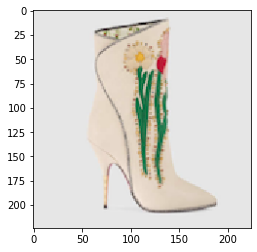

-----------------------------------------------------------------------
most similar products:
similarity score :  0.7132194
similarity score :  0.7076011
similarity score :  0.7071411
similarity score :  0.7019814


<Figure size 288x288 with 0 Axes>

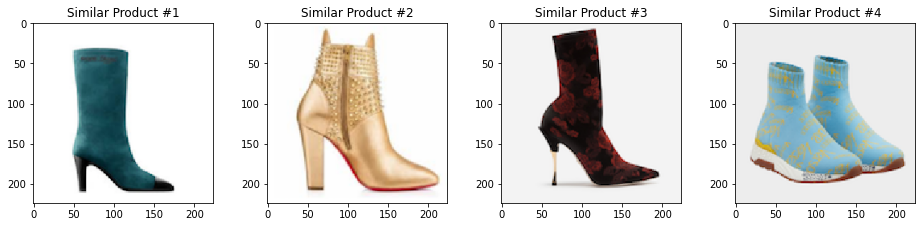

In [ ]:
retrieve_most_similar_products(files[2])


original product:


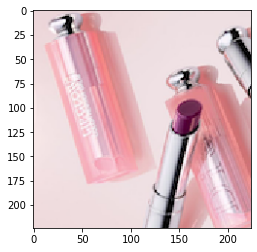

-----------------------------------------------------------------------
most similar products:
similarity score :  0.6962301
similarity score :  0.684223
similarity score :  0.67106575
similarity score :  0.66577697


<Figure size 288x288 with 0 Axes>

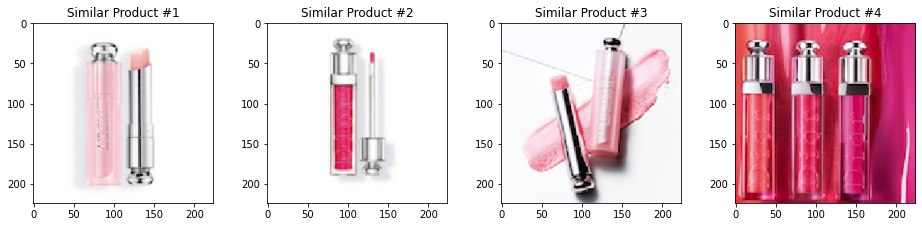

In [ ]:
retrieve_most_similar_products(files[5])

original product:


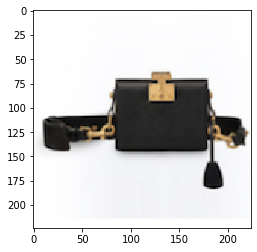

-----------------------------------------------------------------------
most similar products:
similarity score :  0.5951478
similarity score :  0.5894197
similarity score :  0.58704436
similarity score :  0.5803004


<Figure size 288x288 with 0 Axes>

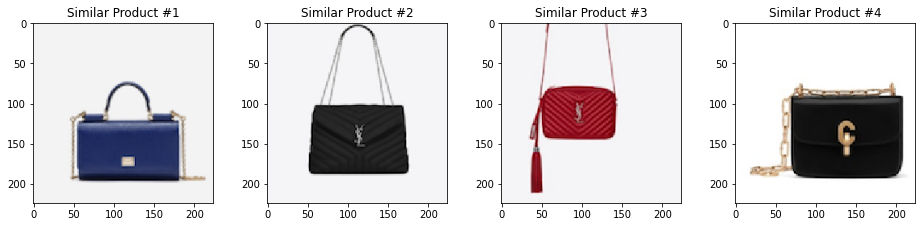

In [ ]:
retrieve_most_similar_products(files[3])

original product:


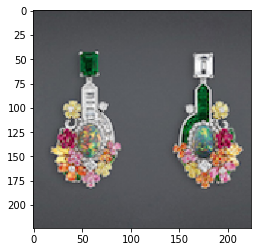

-----------------------------------------------------------------------
most similar products:
similarity score :  0.7599282
similarity score :  0.7430061
similarity score :  0.73590434
similarity score :  0.72436607


<Figure size 288x288 with 0 Axes>

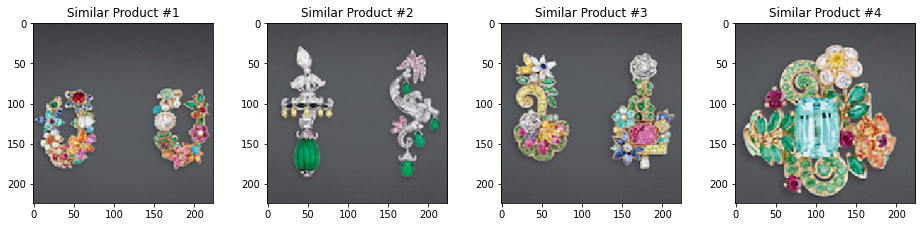

In [ ]:
retrieve_most_similar_products(files[21])

original product:


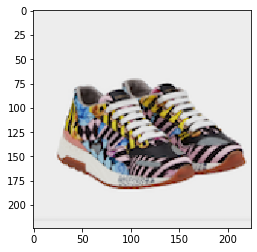

-----------------------------------------------------------------------
most similar products:
similarity score :  0.65461004
similarity score :  0.64272255
similarity score :  0.62508494
similarity score :  0.61658454


<Figure size 288x288 with 0 Axes>

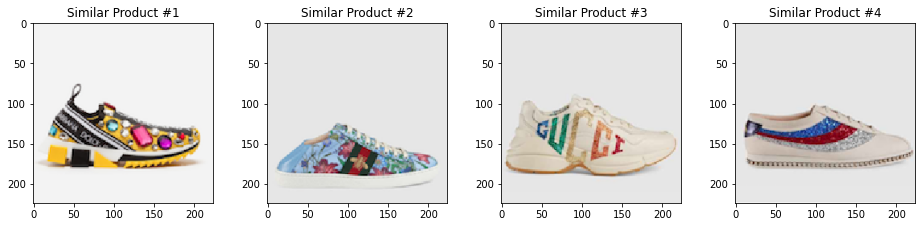

In [ ]:
retrieve_most_similar_products(files[39])

original product:


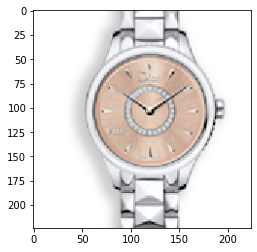

-----------------------------------------------------------------------
most similar products:
similarity score :  0.71470606
similarity score :  0.68633515
similarity score :  0.6841494
similarity score :  0.665223


<Figure size 288x288 with 0 Axes>

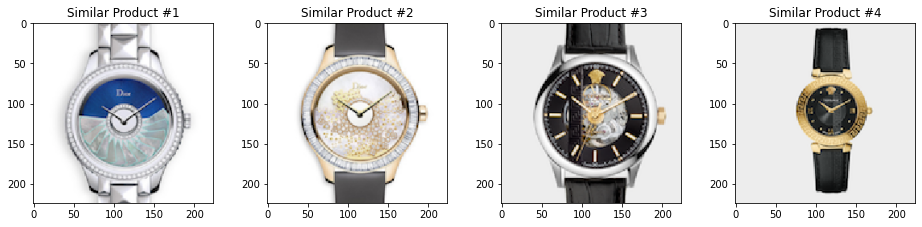

In [ ]:
retrieve_most_similar_products(files[19])

original product:


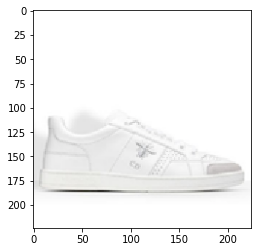

-----------------------------------------------------------------------
most similar products:
similarity score :  0.8101729
similarity score :  0.79680896
similarity score :  0.7835091
similarity score :  0.76583815


<Figure size 288x288 with 0 Axes>

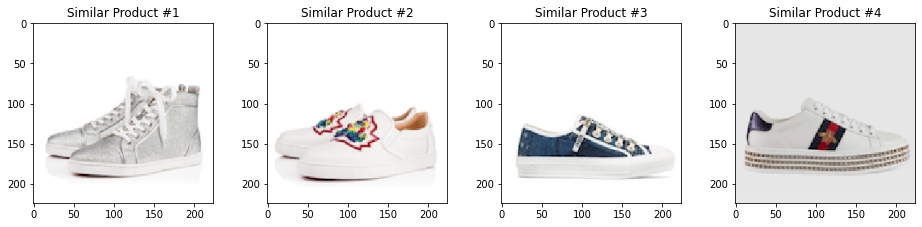

In [ ]:
retrieve_most_similar_products(files[32])

original product:


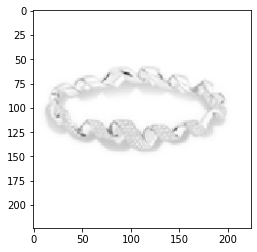

-----------------------------------------------------------------------
most similar products:
similarity score :  0.73513824
similarity score :  0.70867664
similarity score :  0.70207936
similarity score :  0.6931576


<Figure size 288x288 with 0 Axes>

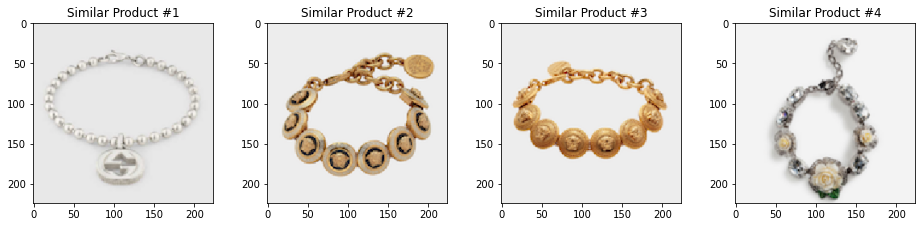

In [ ]:
retrieve_most_similar_products(files[25])

original product:


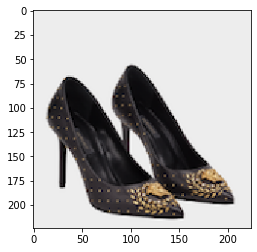

-----------------------------------------------------------------------
most similar products:
similarity score :  0.76350176
similarity score :  0.74000597
similarity score :  0.73638886
similarity score :  0.72032547


<Figure size 288x288 with 0 Axes>

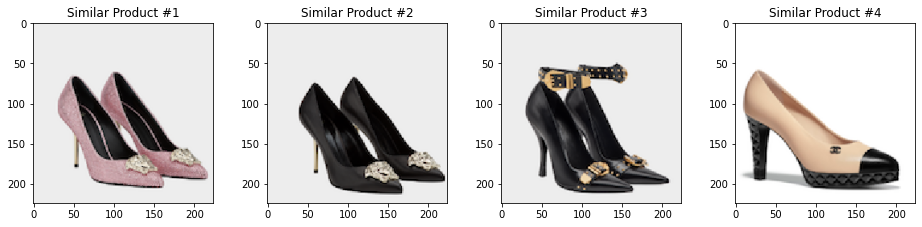

In [ ]:
retrieve_most_similar_products(files[44])

original product:


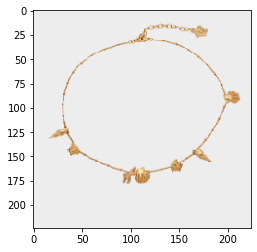

-----------------------------------------------------------------------
most similar products:
similarity score :  0.87161845
similarity score :  0.8679849
similarity score :  0.85260725
similarity score :  0.8308227


<Figure size 288x288 with 0 Axes>

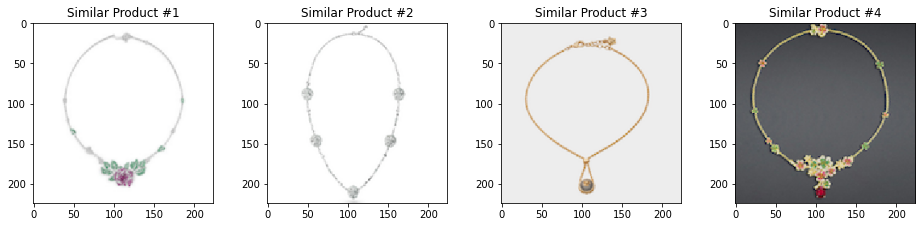

In [ ]:
retrieve_most_similar_products(files[27])

original product:


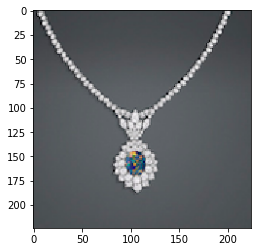

-----------------------------------------------------------------------
most similar products:
similarity score :  0.7776952
similarity score :  0.76146847
similarity score :  0.7531627
similarity score :  0.744568


<Figure size 288x288 with 0 Axes>

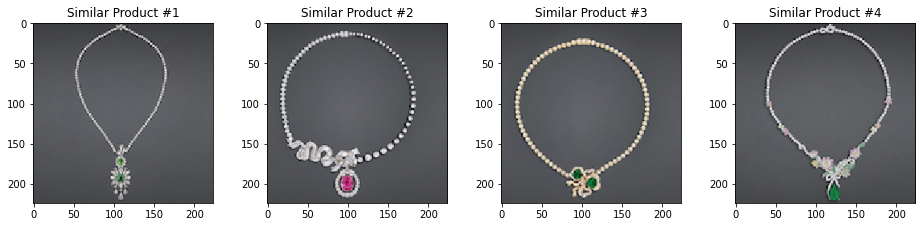

In [ ]:
retrieve_most_similar_products(files[47])